In [45]:

import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

print(np.__version__)
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1.19.5
2.5.0
1 Physical GPUs, 1 Logical GPUs


In [46]:

seq_length=8
x_data_dim=4
batch_size=100
min_max_normalization_flag=True

data_dir = '../dataset'
fname = os.path.join(data_dir, 'data-02-stock_daily.csv')
df = pd.read_csv(fname)
dataset=df.copy()
ori_Y=dataset.pop("Close")
ori_X=dataset.copy()


In [47]:

X_train, X_test, Y_train, Y_test = train_test_split(ori_X,ori_Y, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val= train_test_split(X_train,Y_train, test_size=0.2, shuffle=False)


In [48]:

## 데이터의 min , max, mean, std 값 구하기.
dataset_stats = X_train.describe()
dataset_stats = dataset_stats.transpose()

## data normalization
def min_max_norm(x):
  return (x - dataset_stats['min']) / (dataset_stats['max'] - dataset_stats['min'])

def standard_norm(x):
  return (x - dataset_stats['mean']) / dataset_stats['std']

if min_max_normalization_flag==True:
    min_max_norm_train_data = min_max_norm(X_train)
    min_max_norm_val_data = min_max_norm(X_val)
    min_max_norm_test_data = min_max_norm(X_test)

    data_gen_train=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_train_data.values.tolist(), Y_train.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,
                                                                        batch_size=batch_size)
    data_gen_val=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_val_data.values.tolist(), Y_val.values.tolist(),
                                                                       length=seq_length, sampling_rate=1,
                                                                       batch_size=batch_size)
    data_gen_test=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_test_data.values.tolist(), Y_test.values.tolist(),
                                                                       length=seq_length, sampling_rate=1,
                                                                       batch_size=batch_size)
else:
    data_gen_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_train.values.tolist(),Y_train.values.tolist(),
                                                                   length=seq_length, sampling_rate=1,
                                                                   batch_size=batch_size)
    data_gen_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_val.values.tolist(),Y_val.values.tolist(),
                                                                   length=seq_length, sampling_rate=1,
                                                                   batch_size=batch_size)
    data_gen_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_test.values.tolist(),Y_test.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,
                                                                        batch_size=batch_size)


In [49]:

input_Layer = tf.keras.layers.Input(shape=(seq_length, x_data_dim))
x= tf.keras.layers.SimpleRNN(20, activation='tanh', return_sequences=True)(input_Layer)
x= tf.keras.layers.SimpleRNN(20, activation='tanh',  return_sequences=True)(x)
#x= tf.keras.layers.SimpleRNN(20)(input_Layer, return_sequences=True)(x)
#x= tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(20,activation='relu')(x)
x=tf.keras.layers.Dense(10,activation='relu')(x)
Out_Layer=tf.keras.layers.Dense(1,activation=None)(x)
model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()



Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 8, 4)]            0         
_________________________________________________________________
simple_rnn_26 (SimpleRNN)    (None, 8, 20)             500       
_________________________________________________________________
simple_rnn_27 (SimpleRNN)    (None, 8, 20)             820       
_________________________________________________________________
dense_24 (Dense)             (None, 8, 20)             420       
_________________________________________________________________
dense_25 (Dense)             (None, 8, 10)             210       
_________________________________________________________________
dense_26 (Dense)             (None, 8, 1)              11        
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________

In [50]:

loss_function=tf.keras.losses.mean_squared_error
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.mean_absolute_error
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model.fit(
      data_gen_train,
      validation_data=data_gen_val,
      steps_per_epoch=len(X_train)/batch_size,
      epochs=500,
    validation_freq=1
)
print(model.evaluate(data_gen_test))


Epoch 1/500
4/4 [==============================] - 2s 172ms/step - loss: 498714.7812 - mean_absolute_error: 701.1725 - val_loss: 288111.1562 - val_mean_absolute_error: 536.4282
Epoch 2/500
4/4 [==============================] - 0s 35ms/step - loss: 498438.0312 - mean_absolute_error: 700.9802 - val_loss: 288041.2500 - val_mean_absolute_error: 536.3635
Epoch 3/500
4/4 [==============================] - 0s 32ms/step - loss: 498147.0000 - mean_absolute_error: 700.7798 - val_loss: 287925.3438 - val_mean_absolute_error: 536.2562
Epoch 4/500
4/4 [==============================] - 0s 37ms/step - loss: 497750.7500 - mean_absolute_error: 700.5059 - val_loss: 287745.2812 - val_mean_absolute_error: 536.0892
Epoch 5/500
4/4 [==============================] - 0s 48ms/step - loss: 497345.5625 - mean_absolute_error: 700.2142 - val_loss: 287488.7812 - val_mean_absolute_error: 535.8510
Epoch 6/500
4/4 [==============================] - 0s 30ms/step - loss: 496809.4375 - mean_absolute_error: 699.8350 - v

실제가격: 533.212, 예상가격: 537.109
실제가격: 544.492, 예상가격: 539.869
실제가격: 560.883, 예상가격: 549.773
실제가격: 572.503, 예상가격: 566.166
실제가격: 563.743, 예상가격: 568.906
실제가격: 577.353, 예상가격: 571.812
실제가격: 575.283, 예상가격: 581.747
실제가격: 570.083, 예상가격: 579.709
실제가격: 568.273, 예상가격: 571.680
실제가격: 577.363, 예상가격: 573.926
실제가격: 576.363, 예상가격: 578.854
실제가격: 577.103, 예상가격: 578.259
실제가격: 575.063, 예상가격: 578.986
실제가격: 587.993, 예상가격: 583.192
실제가격: 581.133, 예상가격: 586.794
실제가격: 587.373, 예상가격: 588.390
실제가격: 596.083, 예상가격: 591.909
실제가격: 589.273, 예상가격: 589.113
실제가격: 584.773, 예상가격: 593.976
실제가격: 579.953, 예상가격: 585.673
실제가격: 573.103, 예상가격: 579.005
실제가격: 575.623, 예상가격: 574.502
실제가격: 581.353, 예상가격: 580.291
실제가격: 583.103, 예상가격: 584.174
실제가격: 581.013, 예상가격: 584.883
실제가격: 589.723, 예상가격: 587.914
실제가격: 586.083, 예상가격: 591.225
실제가격: 581.983, 예상가격: 587.798
실제가격: 577.943, 예상가격: 585.083
실제가격: 577.333, 예상가격: 583.125
실제가격: 571.603, 예상가격: 576.835
실제가격: 569.203, 예상가격: 574.493
실제가격: 571.003, 예상가격: 572.890
실제가격: 577.863, 예상가격: 576.024
실제가격: 580.203,

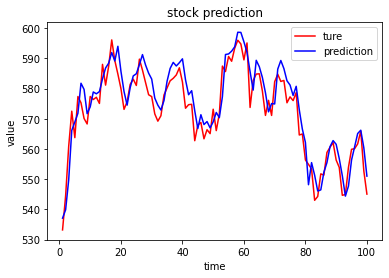

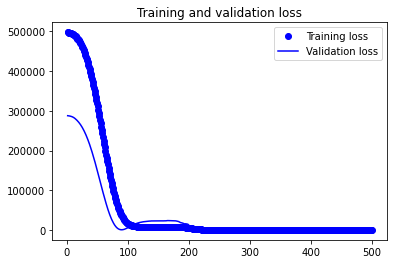

In [32]:

test_data_X, test_data_Y=data_gen_test[0]
prediction_Y=model.predict(test_data_X).flatten()
Y_test=test_data_Y.flatten()

visual_y=[]
visual_pre_y=[]
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))
    visual_y.append(label)
    visual_pre_y.append(prediction)

time = range(1, len(visual_y) + 1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()